# Carregando chaves de api

In [175]:
from dotenv import load_dotenv
import os

os.environ['GROQ_API_KEY'] = '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'

# Definindo e chamando modelos que vão ser usados

In [177]:
from langchain_groq import ChatGroq

class Modelos:
    def __init__(self):
        self.models = {
            'google_gemma': 'gemma2-9b-it',
            'meta_llama': 'llama-3.3-70b-versatile',
            'deep_seek': 'deepseek-r1-distill-qwen-32b'
        }

        self.google_llm = ChatGroq(model=self.models['google_gemma'])
        self.meta_llm = ChatGroq(model=self.models['meta_llama'])
        self.deep_seek_llm = ChatGroq(model=self.models['deep_seek'])

    def imprimir_llms_carregadas(self):
        print(f'GOOGLE_LLM: {self.google_llm}\n')
        print(f'META_LLM: {self.meta_llm}\n')
        print(f'DEEP_SEEK_LLM: {self.deep_seek_llm}\n')

new_obj = Modelos()
new_obj.imprimir_llms_carregadas()

GOOGLE_LLM: client=<groq.resources.chat.completions.Completions object at 0x7f3b97fb75f0> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f3be89786b0> model_name='gemma2-9b-it' model_kwargs={} groq_api_key=SecretStr('**********')

META_LLM: client=<groq.resources.chat.completions.Completions object at 0x7f3b97e002c0> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f3b97e00440> model_name='llama-3.3-70b-versatile' model_kwargs={} groq_api_key=SecretStr('**********')

DEEP_SEEK_LLM: client=<groq.resources.chat.completions.Completions object at 0x7f3b97e025d0> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f3b97e037a0> model_name='deepseek-r1-distill-qwen-32b' model_kwargs={} groq_api_key=SecretStr('**********')



# Carregar Lista de PDFS dos Prospectos

In [8]:
from langchain_community.document_loaders import PyPDFLoader
import os

# Lista para armazenar os documentos carregados
diretorio_base='../data/minuta/'
docs_list = []
i = 1

# Itera sobre os arquivos no diretório e carrega os PDFs
for nome_arquivo in os.listdir(diretorio_base):
    if nome_arquivo.endswith(".pdf"):  # Verifica se o arquivo é um PDF
        caminho_pdf = os.path.join(diretorio_base, nome_arquivo)

        loader = PyPDFLoader(caminho_pdf)

        print(f'loader: {loader}\n\n')
                
        docs = await loader.aload()

        print(f'docs_loader: {docs[0].page_content[:100]}\n\n')
        print(docs[0].metadata)
        
        docs_list.append(docs)

        print(i)
        # i += 1
    if i == 1:
        break


loader: <langchain_community.document_loaders.pdf.PyPDFLoader object at 0x7f3c6234aea0>


docs_loader: ESTE DOCUMENTO É UMA MINUTA INICIAL SUJEITA A ALTERAÇÕES E COMP LEMENTAÇÕES, TENDO SIDO ARQUIVADO NA


{'producer': 'Acrobat Distiller 10.0.0 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2020-10-21T17:41:47-03:00', 'author': '', 'moddate': '2020-10-21T17:44:00-03:00', 'title': '', 'source': '../data/minuta/uni_co_20201021_Minuta%20do%20Prospecto%20Preliminar.pdf', 'total_pages': 667, 'page': 0, 'page_label': '1'}
1


# Dividir Texto em partes menores

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,  # chunk size (characters)
    chunk_overlap=150,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs_list[0])

print(len(all_splits))  # ler tamanho total de divisões
len(all_splits[0].page_content)  # ler tamanho total de divisões da pagina 0

all_splits[10].metadata   # metadados do doc

2147


{'producer': 'Acrobat Distiller 10.0.0 (Windows)',
 'creator': 'PScript5.dll Version 5.2.2',
 'creationdate': '2020-10-21T17:41:47-03:00',
 'author': '',
 'moddate': '2020-10-21T17:44:00-03:00',
 'title': '',
 'source': '../data/minuta/uni_co_20201021_Minuta%20do%20Prospecto%20Preliminar.pdf',
 'total_pages': 667,
 'page': 0,
 'page_label': '1',
 'start_index': 8486}

# Instanciando Embedding

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

print(embeddings)

/home/thayson/Repositorios/llm_testing/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model_name='sentence-transformers/all-mpnet-base-v2' cache_folder=None model_kwargs={} encode_kwargs={} multi_process=False show_progress=False


# Usando InMemoryVectorStore para armazenar os embeddings

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Criando o vector store na memória (evita FAISS caso não queira instalar)
vector_store = InMemoryVectorStore(embeddings)

# Configuração do tamanho do lote e número de threads
batch_size = 4  # Processa poucos documentos por vez para reduzir o uso de RAM
num_threads = 4  # Número de lotes processados simultaneamente
document_ids = []

# Função para processar um lote e armazenar no vector store
def process_batch(start_idx):
    batch = all_splits[start_idx : start_idx + batch_size]
    return vector_store.add_documents(documents=batch)

# Cria um pool de threads para paralelizar a execução
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = {executor.submit(process_batch, i): i for i in range(0, len(all_splits), batch_size)}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processando lotes em paralelo"):
        document_ids.append(future.result())  # Armazena os IDs processados

print("✅ Processamento concluído com paralelismo!")

Processando lotes em paralelo: 100%|██████████| 537/537 [10:43<00:00,  1.20s/it]

✅ Processamento concluído com paralelismo!


# usando a gpu

In [204]:
pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/rocm6.2/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/nightly/rocm6.2/
  Using cached https://download.pytorch.org/whl/nightly/rocm6.2/torchvision-0.20.0.dev20241206%2Brocm6.2-cp312-cp312-linux_x86_64.whl (2.7 MB)
  Using cached https://download.pytorch.org/whl/nightly/rocm6.2/torchaudio-2.5.0.dev20241206%2Brocm6.2-cp312-cp312-linux_x86_64.whl (1.7 MB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch

# Verifica se a GPU AMD (ROCm) está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Processa os batches na GPU com PyTorch
def process_batch_on_gpu(batch):
    batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
    output_tensor = batch_tensor * 2  # Exemplo de operação
    return output_tensor.cpu().numpy().tolist()

document_ids = [process_batch_on_gpu(all_splits[i:i+batch_size]) for i in range(0, len(all_splits), batch_size)]

print("✅ Processamento concluído na GPU AMD via PyTorch!")


# Prompt

In [103]:
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

/home/thayson/Repositorios/llm_testing/env/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [105]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [179]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = new_obj.deep_seek_llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

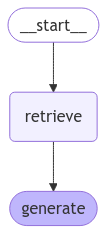

In [231]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [243]:
result = graph.invoke({"question": "me de informações gerais e resumidas do documento"})

# print(f'Context: {result["context"]}\n\n')
# print(f'Answer: {result["answer"]}')
print(result)

{'question': 'me de informações gerais e resumidas do documento', 'context': [Document(id='f11f2934-7728-426b-82c8-46e7dbc2968c', metadata={'producer': 'Acrobat Distiller 10.0.0 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2020-10-21T17:41:47-03:00', 'author': '', 'moddate': '2020-10-21T17:44:00-03:00', 'title': '', 'source': '../data/minuta/uni_co_20201021_Minuta%20do%20Prospecto%20Preliminar.pdf', 'total_pages': 667, 'page': 8, 'page_label': '9', 'start_index': 1773}, page_content='As informações constantes do nosso website não são parte \nintegrante deste Prospecto, e nem se encontram incorporadas \npor referência ou anexas a este. \nInformações Adicionais Informações adicionais sobre nós e a Oferta poderão ser \nobtidas em nosso Formulário de Referência, anexo a este \nProspecto a partir da página 325 deste Prospecto, e junto: (i) à \nnossa Diretoria de Relações com Investidores; (ii) ao \nCoordenador Líder nos endereços e websites indicados na \nseção “Inf